# Import Packages/Library yang akan digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import random
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image

In [3]:
# install tensorflowjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

2025-06-10 18:19:46.951229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749579587.181934      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749579587.249683      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# menonaktifkan warning yang mungkin muncul
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [6]:
path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"
output_path = "/kaggle/working/Skin-disease-images"

# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(path, output_path)

Class counts: [1257, 3323, 1677, 2103, 2079, 1702, 2055, 1847, 3140, 7970]


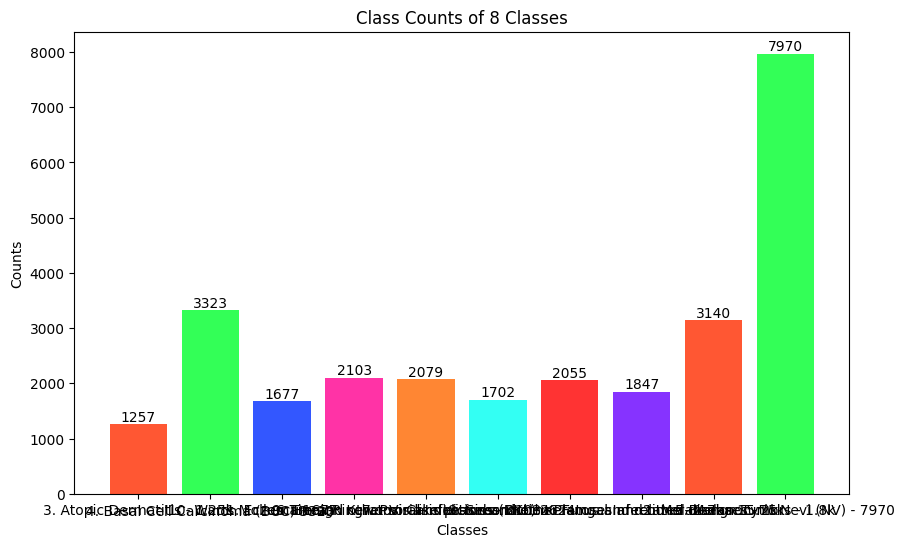

In [7]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6', 
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

In [8]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target
    
    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []
        
        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break
        
        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [9]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Processed 7021/7000 images for 1. Eczema 1677
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Processed 7012/7000 images for 2. Melanoma 15.75k
Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
Oversampling and undersampling completed successfully.


In [10]:
# Membuat List Data
data = []
for class_name in os.listdir(output_path):
    class_dir = os.path.join(output_path, class_name)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, img_file)
            data.append([file_path, class_name])

# Membuat data frame
df = pd.DataFrame(data, columns=['img', 'label'])

print(df.head())

                                                 img  \
0  /kaggle/working/Skin-disease-images/3. Atopic ...   
1  /kaggle/working/Skin-disease-images/3. Atopic ...   
2  /kaggle/working/Skin-disease-images/3. Atopic ...   
3  /kaggle/working/Skin-disease-images/3. Atopic ...   
4  /kaggle/working/Skin-disease-images/3. Atopic ...   

                          label  
0  3. Atopic Dermatitis - 1.25k  
1  3. Atopic Dermatitis - 1.25k  
2  3. Atopic Dermatitis - 1.25k  
3  3. Atopic Dermatitis - 1.25k  
4  3. Atopic Dermatitis - 1.25k  


In [11]:
#ganti nama label
label_mapping = {
    '1. Eczema 1677': 'Eczema',
    '2. Melanoma 15.75k': 'Melanoma',
    '3. Atopic Dermatitis - 1.25k': 'Atopic Dermatitis',
    '4. Basal Cell Carcinoma (BCC) 3323': 'Basal Cell Carcinoma (BCC)',
    '5. Melanocytic Nevi (NV) - 7970': 'Melanocytic Nevi (NV)',
    '6. Benign Keratosis-like Lesions (BKL) 2624': 'Benign Keratosis-like Lesions (BKL)',
    '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 'Psoriasis pictures Lichen Planus and related diseases',
    '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 'Seborrheic Keratoses and other Benign Tumors',
    '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 'Tinea Ringworm Candidiasis and other Fungal Infections',
    '10. Warts Molluscum and other Viral Infections - 2103': 'Warts Molluscum and other Viral Infections'
}

df['label'] = df['label'].replace(label_mapping)

In [12]:
# Melihat banyaknya data pada setiap label
df.groupby('label', as_index=False).count()

,label,img
0,Atopic Dermatitis,6971
1,Basal Cell Carcinoma (BCC),6983
2,Benign Keratosis-like Lesions (BKL),6971
3,Eczema,6976
4,Melanocytic Nevi (NV),7000
5,Melanoma,6989
6,Psoriasis pictures Lichen Planus and related d...,6975
7,Seborrheic Keratoses and other Benign Tumors,6992
8,Tinea Ringworm Candidiasis and other Fungal In...,6963
9,Warts Molluscum and other Viral Infections,6989


/tmp/ipykernel_19/1583116689.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_images = df.groupby('label', as_index=False).apply(lambda x: x.sample(n=5, random_state=1)).reset_index(drop=True)


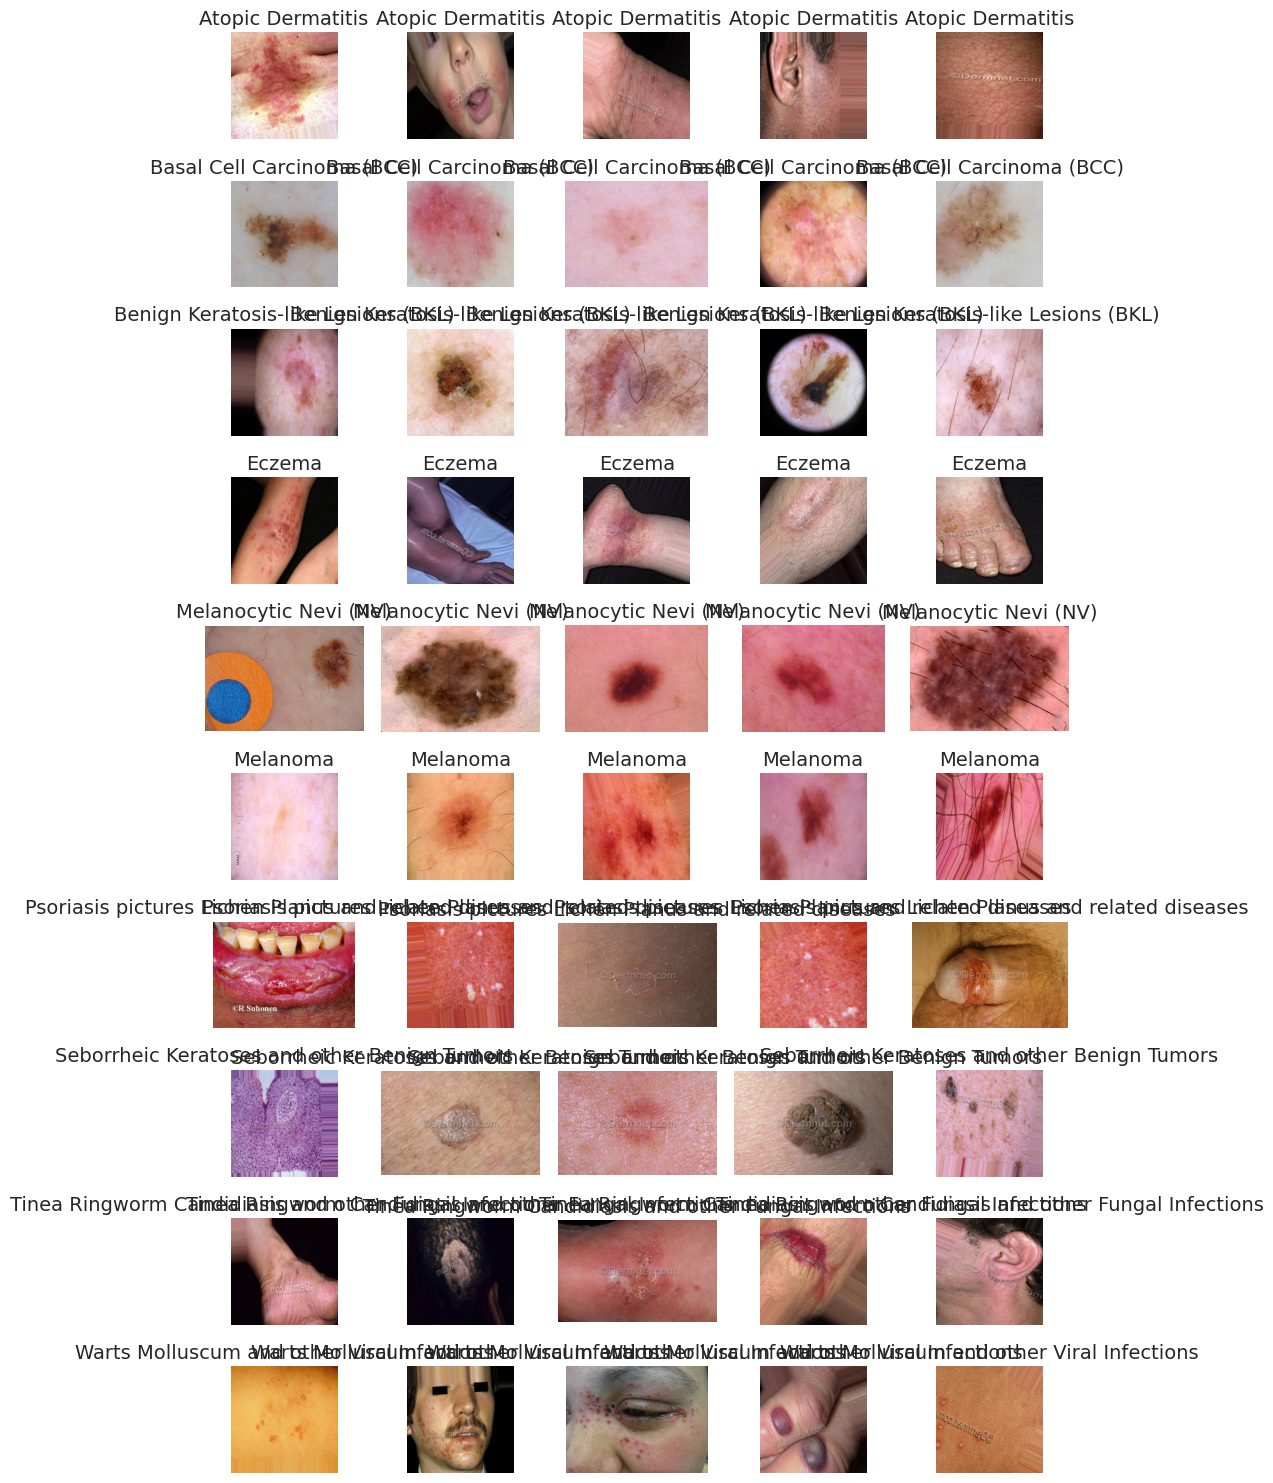

In [13]:
labels = df.label.unique()

# Data visualisasi pakai Seaborn
selected_images = df.groupby('label', as_index=False).apply(lambda x: x.sample(n=5, random_state=1)).reset_index(drop=True)

sns.set(style='whitegrid')
fig, axes = plt.subplots(len(labels), 5, figsize=(9, len(labels)*1.5))

axes = axes.flatten()

for ax, (img_path, label) in zip(axes, zip(selected_images['img'], selected_images['label'])):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label, fontsize=14)

plt.tight_layout()
plt.show()

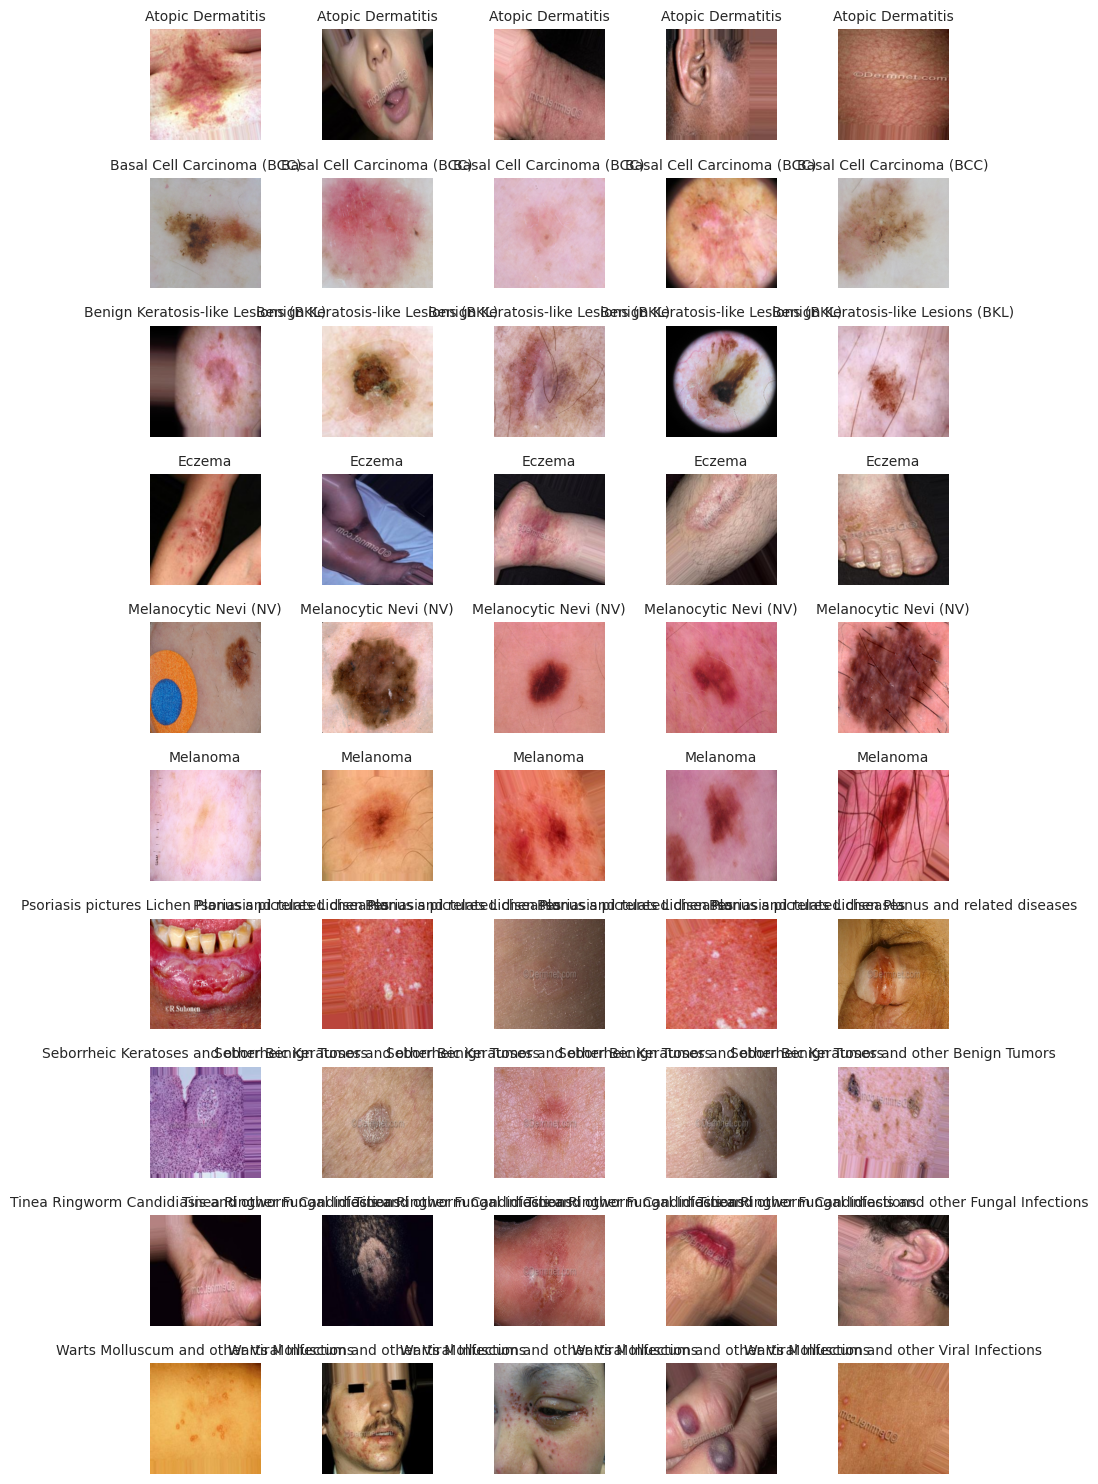

In [14]:
# Ukuran tetap untuk semua gambar
image_size = (224, 224)

sns.set(style='whitegrid')
fig, axes = plt.subplots(len(labels), 5, figsize=(9, len(labels)*1.5))
axes = axes.flatten()

for ax, (img_path, label) in zip(axes, zip(selected_images['img'], selected_images['label'])):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)  # Ubah ukuran gambar di sini
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label, fontsize=10)  # Sedikit kecil agar muat

plt.tight_layout()
plt.show()

## Data Splitting

In [15]:
# Acak dulu dataset (meskipun stratify juga mengacak internalnya)
df = df.sample(frac=1, random_state=32).reset_index(drop=True)

# Split 80% train dan 20% temp (val + test)
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

# Split 20% temp menjadi 10% val dan 10% test
validation_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

In [16]:
# Jumlah gambar per batch saat training
batch_size = 16

# Shape input untuk model (tinggi, lebar, channel RGB)
input_shape = (224, 224, 3)

# Definisikan augmentasi untuk training
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisasi piksel
    rotation_range=40,       # Rotasi acak hingga 40 derajat
    width_shift_range=0.2,   # Pergeseran horizontal acak hingga 20% lebar
    height_shift_range=0.2,  # Pergeseran vertikal acak hingga 20% tinggi
    shear_range=0.2,         # Shear transformation hingga 20%
    zoom_range=0.2,          # Zoom acak hingga 20%
    horizontal_flip=True,    # Izinkan flip horizontal acak
    fill_mode='nearest'      # Isi piksel baru dengan piksel terdekat
)

# Membuat generator untuk data training, testing dan validation
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

validation_data = datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='img',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='img',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 55847 validated image filenames belonging to 10 classes.
Found 6981 validated image filenames belonging to 10 classes.
Found 6981 validated image filenames belonging to 10 classes.


In [17]:
print("Class Indices:", train_data.class_indices)

Class Indices: {'Atopic Dermatitis': 0, 'Basal Cell Carcinoma (BCC)': 1, 'Benign Keratosis-like Lesions (BKL)': 2, 'Eczema': 3, 'Melanocytic Nevi (NV)': 4, 'Melanoma': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Seborrheic Keratoses and other Benign Tumors': 7, 'Tinea Ringworm Candidiasis and other Fungal Infections': 8, 'Warts Molluscum and other Viral Infections': 9}


# Modelling CNN

In [18]:
# Membuat model berurutan (Sequential), setiap layer ditambahkan satu per satu
model = Sequential()
model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: jumlah neuron = jumlah kelas, aktivasi softmax untuk multi-class classification
model.add(Dense(len(labels), activation='softmax'))

# Kompilasi model: optimizer Adam, loss categorical_crossentropy (karena multi-class), metric accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1749580358.691162      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
# CallBack
# Berhenti training jika val_loss tidak membaik 5 epoch berturut-turut.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Turunkan learning rate jika val_loss tidak membaik dalam 2 epoch.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Mulai training model dengan early stopping dan pengaturan learning rate otomatis.
history = model.fit(train_data, epochs=10, validation_data= validation_data, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749580365.866744      71 service.cc:148] XLA service 0x7f3648085e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749580365.869555      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749580366.347824      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3491 ━━━━━━━━━━━━━━━━━━━━ 9:37:18 10s/step - accuracy: 0.1250 - loss: 2.5254

I0000 00:00:1749580370.819150      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3491/3491 ━━━━━━━━━━━━━━━━━━━━ 729s 206ms/step - accuracy: 0.2987 - loss: 1.8931 - val_accuracy: 0.3325 - val_loss: 1.9652 - learning_rate: 0.0010
Epoch 2/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 713s 204ms/step - accuracy: 0.4729 - loss: 1.4226 - val_accuracy: 0.3114 - val_loss: 2.1722 - learning_rate: 0.0010
Epoch 3/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 704s 201ms/step - accuracy: 0.5698 - loss: 1.1870 - val_accuracy: 0.5814 - val_loss: 1.2996 - learning_rate: 0.0010
Epoch 4/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 714s 204ms/step - accuracy: 0.6258 - loss: 1.0429 - val_accuracy: 0.2501 - val_loss: 6.2236 - learning_rate: 0.0010
Epoch 5/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 715s 205ms/step - accuracy: 0.6668 - loss: 0.9413 - val_accuracy: 0.3511 - val_loss: 4.1440 - learning_rate: 0.0010
Epoch 6/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 706s 202ms/step - accuracy: 0.7160 - loss: 0.8213 - val_accuracy: 0.7850 - val_loss: 0.6936 - learning_rate: 2.0000e-04
Epoch 7/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 707s 202ms/step -

In [20]:
# Mengevaluasi kinerja model di data test
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

437/437 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - accuracy: 0.8191 - loss: 0.5774
Test Loss: 0.5960873961448669
Test Accuracy: 0.8156424760818481


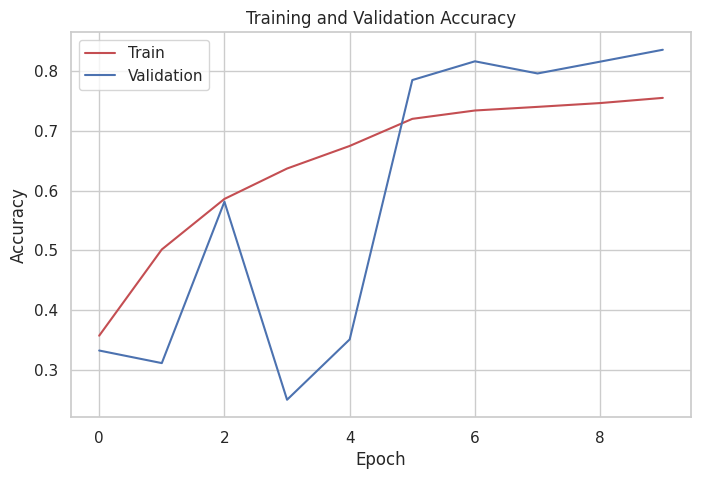

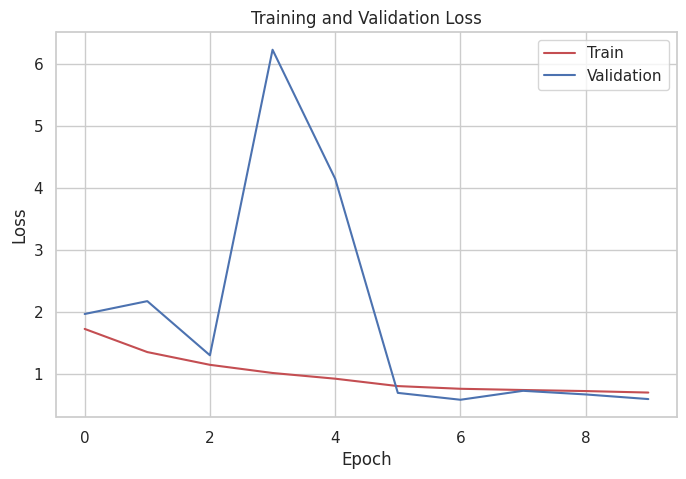

In [21]:
# Ambil nilai dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

437/437 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8321    0.8034    0.8175       697
           1     0.7816    0.9213    0.8457       699
           2     0.8638    0.7920    0.8263       697
           3     0.7539    0.8264    0.7885       697
           4     0.8447    0.7929    0.8180       700
           5     0.8857    0.9199    0.9025       699
           6     0.7635    0.7307    0.7467       698
           7     0.8411    0.8555    0.8482       699
           8     0.8438    0.7687    0.8045       696
           9     0.7562    0.7411    0.7486       699

    accuracy                         0.8152      6981
   macro avg     0.8166    0.8152    0.8147      6981
weighted avg     0.8166    0.8152    0.8147      6981



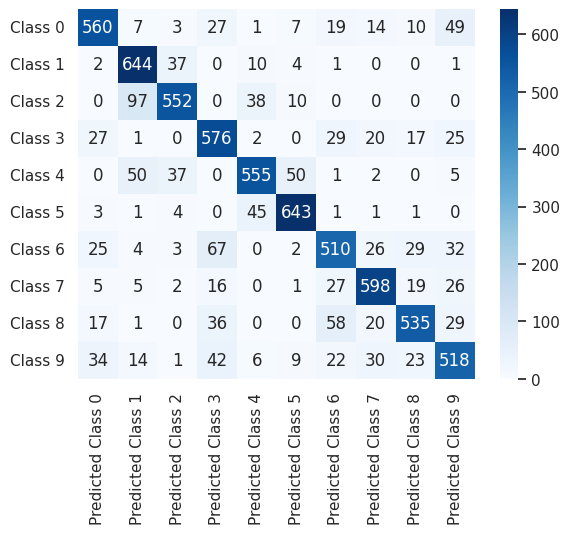

In [22]:
test_data.reset()

preds = model.predict(test_data, verbose=1)

preds_class = np.argmax(preds, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_data.classes, preds_class),
                  index=["Class {}".format(i) for i in range(len(test_data.class_indices))],
                  columns=["Predicted Class {}".format(i) for i in range(len(test_data.class_indices))])

# Visualisasi confusion matrix menggunakan heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(test_data.classes, preds_class, target_names=[str(i) for i in range(len(test_data.class_indices))], digits=4))

# Model Save (TFJS)

In [23]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
shutil.make_archive('saved_model', 'zip', export_dir)

'/kaggle/working/saved_model.zip'

In [24]:
output_dir = 'tfjs_model'
tfjs.converters.save_keras_model(model, 'tfjs_model')
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model/')

failed to lookup keras version from the file,
    this is likely a weight only file


'/kaggle/working/tfjs_model.zip'

In [25]:
model.save('model.h5')